In [1]:
#shutil.rmtree('./data')
import tensorflow as tf
from keras import backend as K
from keras import optimizers
from tensorflow.keras.optimizers import Adam
#import keras.backend.tensorflow_backend as KTF
from tensorflow.python.keras.backend import get_session
import glob
from keras.layers import Input,Dense,Dropout,BatchNormalization,Conv2D,MaxPooling2D,AveragePooling2D,concatenate,Activation,ZeroPadding2D
import cv2
import numpy as np
import pandas as pd
import keras as kr
from keras.models import load_model
from keras.layers import Activation, Dense
from matplotlib import pyplot as plt
from skimage import io,data
import time
#from keras import layers
#from keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow import keras 
from tensorflow.python.keras.callbacks import TensorBoard, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

# Run of Cropnet new attention model applying on breast cancer dataset
dataset: Breast Histopathology Images. 
https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images?datasetId=7415. 
Model: A 2nd version of light attention model designed for crop disease identification. 
from paper: 
Automatic identification of commodity label images using lightweight attention network, 
from Group of Prof Defu Zhang @ Xiamen University. DOI:doi.org/10.1007/s00521-021-06081-9

In [2]:
##在kaggle中建立工作目录
import os
os.makedirs('../working/data/train_seg/idc-minus/')     
os.makedirs('../working/data/train_seg/idc-plus/')  
os.makedirs('../working/data/test_seg/idc-minus/')     
os.makedirs('../working/data/test_seg/idc-plus/')  
os.makedirs('../working/data/val_seg/idc-minus/')     
os.makedirs('../working/data/val_seg/idc-plus/')  


In [3]:
##全局变量声明
sampling_seed=0
size_4_training=78786
img_x=50
epoch_4_test=40
n_of_classes=2

#training_reshape=(-1, img_size, img_size, 3)

In [4]:
import random
from sklearn.model_selection import train_test_split

import shutil
from glob import glob 
#make directory for labelling

train_dir='../working/data/train_seg/'
validation_dir='../working/data/val_seg/'
#train_dir='../working/data/train_seg/'  
#test_dir = '../working/data/test_seg/normal'  
test_dir = '../working/data/test_seg/'  

class0 = [] # 0 = idc+
class1 = [] # 1 = idc-
imagePatches = glob('../input/breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png', recursive=True)
for filename in imagePatches:
    if filename.endswith("class0.png"):
         class0.append(filename)
    else:
        class1.append(filename)

print(class0[0:10])

#sampling 10000 images from class 0 and class 1 to train the model
##从每类文件名列表中抽样
random.seed(sampling_seed)
class0sample=random.sample(class0,size_4_training)
class0label=np.zeros(size_4_training)
class1sample=random.sample(class1,size_4_training)
class1label=np.ones(size_4_training)
##从每类样本列表中分割train-val-test
class0sample_train, class0sample_test1, class0label_train, class0label_test1 = train_test_split(class0sample, class0label, test_size=0.3, random_state=42)
class0sample_test,class0sample_val,  class0label_test, class0label_val = train_test_split(class0sample_test1, class0label_test1, test_size=0.3, random_state=42)
print(len(class0sample_train))
print(len(class0sample_test))
print(len(class0sample_val))
class1sample_train, class1sample_test1, class1label_train, class1label_test1 = train_test_split(class1sample, class1label, test_size=0.3, random_state=42)
class1sample_test, class1sample_val, class1label_test, class1label_val = train_test_split(class1sample_test1, class1label_test1, test_size=0.3, random_state=42)
print(len(class1sample_train))
print(len(class1sample_test))
print(len(class1sample_val))
##函数功能：将之前文件列表中的文件复制到指定工作目录中
def read_and_save_data(path, file_name_array):
    j=0
    for i in file_name_array:
        if i.endswith('.png'):
          
            
            #second copy method
            head, tail = os.path.split(i)
            outputname=str(path+tail)
            #outputname=str(path+str(j)+'.png')
            #print(outputname)
            shutil.copy(i, outputname)
   
            #print(status2)
            
            j=j+1
            if j==120000:
                break
            
##分别按照每类，train， validation， test保存样本   
class0train_path='../working/data/train_seg/idc-minus/'
class1train_path='../working/data/train_seg/idc-plus/'
class0test_path='../working/data/test_seg/idc-minus/'
class1test_path='../working/data/test_seg/idc-plus/'
class0val_path='../working/data/val_seg/idc-minus/'
class1val_path='../working/data/val_seg/idc-plus/'

read_and_save_data(class0train_path,class0sample_train)
read_and_save_data(class1train_path,class1sample_train)


read_and_save_data(class0test_path,class0sample_test)
read_and_save_data(class1test_path,class1sample_test)


read_and_save_data(class0val_path,class0sample_val)
read_and_save_data(class1val_path,class1sample_val)
##print输出包含两类train，valid，test的大小和每次转存的文件用于检查

['../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1351_y1101_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1501_y501_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1501_y1101_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x451_y901_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x801_y451_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x151_y1051_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1351_y901_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x701_y651_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x951_y1401_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/102

In [5]:
#shutil.rmtree('./data')

**load gen**

In [6]:

import os #Operating System
import sys #System
# train_generator = train_datagen.flow(x_train, y_train, batch_size =)
# val_generator = val_datagen.flow(x_val, y_val, batch_size = 64)
# test_generator=test_datagen.flow(x_test,y_test,batch_size = 64)

In [7]:
##这个模块（cell）把之前存好的每类train-valid-test文件分别读到np。array里
##这个模块在其他模型上进行过测试，也没有问题
import os
import cv2
##函数功能，将指定目录path下的文件读到列表中，并按给定的tag创建
#输入path目标目录，tag目录内所有文件的label（目录内全部一致）
#输出image_data，进行过resize的图片数据array
#输出label，标签列表，列表内每一个数字都是tag，列表大小等于目录内图片数量
def readImage(path, tag):
    j=0
    image_data = []
    label=[]
    for i in os.listdir(path):
        imgname=path+i
        #print(imgname)
        img = cv2.imread(imgname, cv2.IMREAD_COLOR)
        img_resized = cv2.resize(img, (img_x,img_x), interpolation=cv2.INTER_LINEAR)
        image_data.append(img_resized)
        label.append(tag)
        #print(img[1])
        j=j+1
        #if j==10:
        #    break
        
    return image_data, label

import numpy as np
from tensorflow.keras.utils import *
from sklearn.utils import shuffle

class0_train, train0_label = readImage(class0train_path, 0)
class1_train, train1_label  = readImage(class1train_path, 1)
class0_test, test0_label = readImage(class0test_path, 0)
class1_test, test1_label = readImage(class1test_path, 1)
class0_val, val0_label = readImage(class0val_path, 0)
class1_val, val1_label = readImage(class1val_path, 1)
##函数功能，将每类train的图片数据列表和标签列表进行混合并洗牌，或者是validation，或者是test
#class0array，class1array，是train（或valid，或test） 中class0，class1的图片数据列表，label0，label1是标签列表，比如说class0是一个（700，224，224，3）的数据array，700就是图片张数，224是xy尺寸，3是三原色对应的通道。label0就是长度为700，每位都是0的array
#输出中combined_data, combined_label分别是混合并洗牌后的数据和标签。混合通过np。concatenate，洗牌通过shuffle函数，并且combined_label标签进行了hot-coded二进制转换,通过to_categorical函数实现
#函数中包含print检查功能，先显示combined_label的array 的shape，再整个print combined_label，以检查label是否成功二进制化，是否完全平衡
#输出label，标签列表，列表内每一个数字都是tag，列表大小等于目录内图片数量
def Image_array_process(class0array,label0, class1array, label1):
    class0_array=np.array(class0array)
    class1_array=np.array(class1array)
    combined_data = np.concatenate((class0_array, class1_array))
    combined_label= np.concatenate((label0,label1), axis=0)
    assert len(combined_data) == len(combined_label)
    combined_data, combined_label = shuffle(combined_data, combined_label, random_state=0)
    print(combined_data.shape)
    length=len(combined_data)
    combined_label=to_categorical(combined_label,num_classes=2)
    #combined_label=np.array(combined_label,dtype=np.int64)
    #combined_data=np.array(combined_data,dtype=np.int64)
    i=0
    #for i in range(length):
    #    print(combined_label[i])

    #print

    #print(class0_array.shape)
    #print(combined_data.shape)
    '''
    training_reshape=(img_x,img_x,3)
    length=len(combined_data)
    print(length)
    x =[None]*length
    #print(img_data.type)
    y =np.zeros(length)
    i=0
   
    for features,label in combined_data:
        x[i]=features
        #print(x.shape)
        y[i]=label
        #print(y[i])
        i=i+1
    
            #x = np.array(x).reshape(training_reshape)
    x = np.array(x)    
    #print(x.shape)
    #y=np.array(y)
    y=y.astype(int)
    y = to_categorical(y)
    print(y)
    '''  
    return combined_data, combined_label


X_train, y_train=Image_array_process(class0_train, train0_label, class1_train, train1_label)
X_test, y_test=Image_array_process(class0_test, test0_label, class1_test, test1_label)
X_val, y_val=Image_array_process(class0_val, val0_label, class1_val, val1_label)


(110300, 50, 50, 3)
(33090, 50, 50, 3)
(14182, 50, 50, 3)


In [8]:
train_data=X_train
train_label=y_train

test_data=X_test
test_label=y_test

val_data=X_val
val_label=y_val

In [9]:
print(len(train_data))

110300


In [10]:
'''

train_dir='../working/data/train_seg/'  
#test_dir = '../working/data/test_seg/idc-minus'  
test_minus_dir = '../working/data/test_seg/idc-minus' 
img_size = (img_x, img_x)  
epochs = epoch_4_test
MODEL_PATH = '../working/log/tst_model.h5'
board_name1 = '../working/log/stage1/' + now + '/'
board_name2 = '../working/log/stage2/' + now + '/'

#MODEL_PATH = '../working/log/tst_model.h5'
#model.load_weights(MODEL_PATH)
# --------------- test ----------------
dirs = os.listdir(test_minus_dir)

prob_list = []
for d in dirs:
    img = image.load_img(test_minus_dir + os.sep + d, target_size=img_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    y = model.predict(x)
#    print(y)
    #print(classes[np.argmax(y)])
#    print(classes)

    prob_list.append(str(y))   
    file=open('../working/pred_prob.txt','w') 
    file.write('\n'.join(prob_list))
    file.close()
    
#import tensorflow as tf
#config = tf.ConfigProto()
#config.gpu_options.allow_growth = True
#keras.backend.set_session(tf.Session(config=config))
'''

"\n\ntrain_dir='../working/data/train_seg/'  \n#test_dir = '../working/data/test_seg/idc-minus'  \ntest_minus_dir = '../working/data/test_seg/idc-minus' \nimg_size = (img_x, img_x)  \nepochs = epoch_4_test\nMODEL_PATH = '../working/log/tst_model.h5'\nboard_name1 = '../working/log/stage1/' + now + '/'\nboard_name2 = '../working/log/stage2/' + now + '/'\n\n#MODEL_PATH = '../working/log/tst_model.h5'\n#model.load_weights(MODEL_PATH)\n# --------------- test ----------------\ndirs = os.listdir(test_minus_dir)\n\nprob_list = []\nfor d in dirs:\n    img = image.load_img(test_minus_dir + os.sep + d, target_size=img_size)\n    x = image.img_to_array(img)\n    x = np.expand_dims(x, axis=0)\n    y = model.predict(x)\n#    print(y)\n    #print(classes[np.argmax(y)])\n#    print(classes)\n\n    prob_list.append(str(y))   \n    file=open('../working/pred_prob.txt','w') \n    file.write('\n'.join(prob_list))\n    file.close()\n    \n#import tensorflow as tf\n#config = tf.ConfigProto()\n#config.gpu_op

PLTv3

In [11]:
# -*- coding: utf-8 -*-
"""
Created on Sun Jun 16 22:23:24 2020

@author: HP
"""
'''

from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda
from keras import backend as K
from keras.activations import sigmoid


from keras import backend as K
from keras import optimizers
from tensorflow.keras.optimizers import Adam
import keras.backend.tensorflow_backend as KTF
#import tensorflow.python.keras.backend as KTF
import glob
from keras.layers import Input,Dense,Dropout,BatchNormalization,Conv2D,MaxPooling2D,AveragePooling2D,concatenate,Activation,ZeroPadding2D
import tensorflow as tf
import cv2
import numpy as np
import pandas as pd
import keras
from keras.models import load_model
from keras.layers import Activation, Dense
from matplotlib import pyplot as plt
from skimage import io,data
import time
from keras import layers
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.preprocessing.image import ImageDataGenerator

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
now = time.strftime("%Y-%m-%d_%H-%M-%S", time.localtime())

import os,sys
os.getcwd()
#os.chdir("../working/cjd/31_CNN_Attention")

#import tensorflow as tf
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras import regularizers
'''

'\n\nfrom keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda\nfrom keras import backend as K\nfrom keras.activations import sigmoid\n\n\nfrom keras import backend as K\nfrom keras import optimizers\nfrom tensorflow.keras.optimizers import Adam\nimport keras.backend.tensorflow_backend as KTF\n#import tensorflow.python.keras.backend as KTF\nimport glob\nfrom keras.layers import Input,Dense,Dropout,BatchNormalization,Conv2D,MaxPooling2D,AveragePooling2D,concatenate,Activation,ZeroPadding2D\nimport tensorflow as tf\nimport cv2\nimport numpy as np\nimport pandas as pd\nimport keras\nfrom keras.models import load_model\nfrom keras.layers import Activation, Dense\nfrom matplotlib import pyplot as plt\nfrom skimage import io,data\nimport time\nfrom keras import layers\nfrom keras.callbacks import ModelCheckpoint, TensorBoard\nfrom keras.preprocessing.image import ImageDataGenerator\n\nfrom sklearn impo

In [12]:
import os,sys
#os.getcwd()
#os.chdir("/home/cjd/28_Entity_train")
print(os.getcwd())
print (sys.version)


/kaggle/working
3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) 
[GCC 9.4.0]


In [13]:
now = time.strftime("%Y-%m-%d_%H-%M-%S", time.localtime())
#import os
# 
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2,3,5"

'''
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

'''

'\nconfig = tf.ConfigProto()\nconfig.gpu_options.allow_growth = True\nkeras.backend.tensorflow_backend.set_session(tf.Session(config=config))\n\n'

In [14]:
import os
import glob
batch_size = 32 #每批训练数据量的大小，批量多设一些；GoogleNet批量值设为20 2^n
epochs = epoch_4_test
MODEL_INIT = './init_model.h5'
MODEL_PATH = './test_model.h5'
board_name1 = './obj_reco/stage1/' + now + '/'
board_name2 = './obj_reco/stage2/' + now + '/'
train_dir='/data/train_seg/'
validation_dir='/data/test_seg/'
img_size = (img_x, img_x)  # 图片大小
#classes=list(range(1,5))
#classes=['1','2','3','4']
nb_train_samples = len(glob.glob(train_dir + '/*/*.*'))  # 训练样本数
nb_validation_samples = len(glob.glob(validation_dir + '/*/*.*'))  # 验证样本数

#classes = sorted([o for o in os.listdir(train_dir)])  # 根据文件名分类

In [15]:
##添加自定义层
#import tensorflow as tf   

import tensorflow as tf        
def focal_loss(gamma=2.):            
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        return -K.sum( K.pow(1. - pt_1, gamma) * K.log(pt_1)) 
    return focal_loss_fixed


def Conv2d_BN(x, nb_filter,kernel_size, strides=(1,1), padding='same',name=None):  
    if name is not None:  
        bn_name = name + '_bn'  
        conv_name = name + '_conv'  
    else:  
        bn_name = None  
        conv_name = None  
  
    x = Conv2D(nb_filter,kernel_size,padding=padding,strides=strides,activation='relu',name=conv_name)(x)  
    x = BatchNormalization(axis=3,name=bn_name)(x)  
    return x  

def Conv_Block(inpt,nb_filter,kernel_size,strides=(1,1), with_conv_shortcut=False):  
    x = Conv2d_BN(inpt,nb_filter=nb_filter[0],kernel_size=(1,1),strides=strides,padding='same')  
    x = Conv2d_BN(x, nb_filter=nb_filter[1], kernel_size=(3,3), padding='same')  
    x = Conv2d_BN(x, nb_filter=nb_filter[2], kernel_size=(1,1), padding='same')  
    if with_conv_shortcut:  
        shortcut = Conv2d_BN(inpt,nb_filter=nb_filter[2],strides=strides,kernel_size=kernel_size)  
        x = add([x,shortcut])  
        return x  
    else:  
        x = add([x,inpt])  
        return x  

'''

class SeBlock(keras.layers.Layer):   
    def __init__(self, reduction=4,**kwargs):
        super(SeBlock,self).__init__(**kwargs)
        self.reduction = reduction
'''
class SeBlock(keras.layers.Layer):   
    def __init__(self, reduction=4,**kwargs):
        super(SeBlock,self).__init__(**kwargs)
        self.reduction = reduction
    def get_config(self):
        config = super().get_config().copy()
        config.update({'reduction': self.reduction})
        return config
        
    def build(self,input_shape):
    	#input_shape     
    	pass
    def call(self, inputs):
        x = keras.layers.GlobalAveragePooling2D()(inputs)
        x = keras.layers.Dense(int(x.shape[-1]) // self.reduction, use_bias=False,activation=keras.activations.relu)(x)
        x = keras.layers.Dense(int(inputs.shape[-1]), use_bias=False,activation=keras.activations.hard_sigmoid)(x)
        return keras.layers.Multiply()([inputs,x])    
        #return inputs*x 

#------#MS-DenseNet----------------------------------
def get_bottlenet(image_size,alpha=1.0):
    inputs = keras.layers.Input(shape=(image_size,image_size,3),name='input_1')
    net = keras.layers.ZeroPadding2D(padding=(3,3),name='zero_padding2d_1')(inputs)
    net = keras.layers.Conv2D(filters=64, kernel_size=(7,7), strides=(2,2),
                             padding='valid', name='conv1/conv')(net)
    net = keras.layers.BatchNormalization(name='conv1/bn')(net)
    net = keras.layers.ReLU(name='conv1/relu')(net)
    net = keras.layers.ZeroPadding2D(padding=(1,1),name='zero_padding2d_2')(net)
#    se = keras.layers.GlobalAveragePooling2D(name='transform2_pool')(net)
    se=SeBlock()(net)

    net = keras.layers.MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='valid',
                                   name='pool1')(net)
#    se = keras.layers.GlobalAveragePooling2D(name='transform2_pool')(net)
    se=SeBlock()(net)
    
    for i in range(int(3*alpha)):
        block = net
        block = keras.layers.SeparableConv2D(filters=32,kernel_size=(3,3), strides=(1, 1), 
                                    padding='same',
                                    name='conv2_block{}_2_sepconv'.format(i))(block)
        net = keras.layers.Concatenate(name='conv2_block{}_concat'.format(i))([net,block])    
    net = keras.layers.BatchNormalization(name='pool2_bn')(net) 
    net = keras.layers.ReLU(name='pool2_relu')(net)
    eq = keras.layers.Dense(units=net.shape[-1],activation='sigmoid',
                            name='transform2_dense1')(se)
    net = keras.layers.Multiply(name='transform2_multiply')([net,eq])

    net = keras.layers.Conv2D(filters=int(net.shape[-1])//2,kernel_size=(1,1),strides=(1,1),
                              padding='same',name='pool2_conv')(net)
    net = keras.layers.AveragePooling2D(pool_size=(2,2),strides=(2,2),
                                        name='pool2_pool')(net)
#    se = keras.layers.GlobalAveragePooling2D(name='transform3_pool')(net)
    se=SeBlock()(net)

    for i in range(int(6*alpha)):
        block = net
        block = keras.layers.SeparableConv2D(filters=32, kernel_size=(3,3), strides=(1, 1),
                                             padding='same',
                                             name='conv3_block{}_2_sepconv'.format(i))(block)
        net = keras.layers.Concatenate(name='conv3_block{}_concat'.format(i))([net,block])
    net = keras.layers.BatchNormalization(name='pool3_bn')(net) 
    net = keras.layers.ReLU(name='pool3_relu')(net)
    eq = keras.layers.Dense(units=net.shape[-1],activation='sigmoid',
                            name='transform3_dense1')(se)
    net = keras.layers.Multiply(name='transform3_multiply')([net,eq])

    net = keras.layers.Conv2D(filters=int(net.shape[-1])//2,kernel_size=(1,1),strides=(1,1),
                              padding='same',name='pool3_conv')(net)
    net = keras.layers.AveragePooling2D(pool_size=(2,2),strides=(2,2),
                                    name='pool3_pool')(net)
#    se = keras.layers.GlobalAveragePooling2D(name='transform4_pool')(net)
    se=SeBlock()(net)
    for i in range(int(12*alpha)):
        block = net
        block = keras.layers.SeparableConv2D(filters=32, kernel_size=(3,3), strides=(1, 1), 
                                    padding='same',
                                    name='conv4_block{}_2_sepconv'.format(i))(block)
        net = keras.layers.Concatenate(name='conv4_block{}_concat'.format(i))([net,block])
    net = keras.layers.BatchNormalization(name='pool4_bn')(net) 
    net = keras.layers.ReLU(name='pool4_relu')(net)
    eq = keras.layers.Dense(units=net.shape[-1],activation='sigmoid',
                            name='transform4_dense1')(se)
    net = keras.layers.Multiply(name='transform4_multiply')([net,eq])

    net = keras.layers.Conv2D(filters=int(net.shape[-1])//2,kernel_size=(1,1),strides=(1,1),
                             padding='same',name='pool4_conv')(net)
    net = keras.layers.AveragePooling2D(pool_size=(2,2),strides=(2,2),
                                        name='pool4_pool')(net)
#    se = keras.layers.GlobalAveragePooling2D(name='transform5_pool')(net)
    se=SeBlock()(net)
    for i in range(int(8*alpha)):
        block = net
        block = keras.layers.SeparableConv2D(filters=32, kernel_size=(3,3), strides=(1, 1), 
                                    padding='same',
                                    name='conv5_block{}_2_sepconv'.format(i))(block)
        net = keras.layers.Concatenate(name='conv5_block{}_concat'.format(i))([net,block])
       
    eq = keras.layers.Dense(units=net.shape[-1],activation='sigmoid',
                            name='transform5_dense1')(se)
    net = keras.layers.Multiply(name='transform5_multiply')([net,eq])
    net = keras.layers.BatchNormalization(name='bn')(net)
    net = keras.layers.ReLU(name='relu')(net)
    model = keras.Model(inputs=inputs,outputs=net,name='mobile_densenet_bottle')
    return model

#原文中软注意力模块的组装

def get_model(image_size, alpha, classes):
    bottlenet = get_bottlenet(alpha=alpha,image_size=image_size)
    net = keras.layers.GlobalAveragePooling2D(name='global_pool')(bottlenet.output)
    net = keras.layers.Dropout(rate=0.4,name='dropout1')(net)
    net = keras.layers.Dropout(rate=0.4,name='dropout2')(net)
    output = keras.layers.Dense(units=classes,activation='softmax',
                             name='prediction')(net)
    model = keras.Model(inputs=bottlenet.input,outputs=output,name='mobile_densenet')
    return model
model = get_model(image_size=img_x, alpha=1.0, classes=n_of_classes)
model.summary()

2022-06-02 23:37:42.936657: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "mobile_densenet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50, 50, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 56, 56, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 25, 25, 64)   9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 25, 25, 64)   256         conv1/conv[0][0]                 
____________________________________________________________________________________

In [16]:
#train_datagen = ImageDataGenerator(validation_split=0.2)
#train_datagen = ImageDataGenerator()

train_datagen1 = ImageDataGenerator(#rescale = 1.0/255,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1,
                                  fill_mode = 'constant',
                                  zoom_range = 0.1,
                                  rotation_range = 20)

#train_datagen.mean = np.array([103.939, 116.779, 123.68], dtype=np.int64).reshape((3, 1, 1))  # remove imagenet BGR mean value
#train_generator = train_datagen.flow(train_data, train_label, target_size=img_size, classes=classes)
train_generator1 = train_datagen1.flow(train_data, train_label)

validation_datagen = ImageDataGenerator(rescale = 1.0/255)
#validation_datagen.mean = np.array([103.939, 116.779, 123.68], dtype=np.int64).reshape((3, 1, 1))
test_dir = '../working/data/test_seg/'  
#val_generator = validation_datagen.flow(test_data, test_label, target_size=img_size, classes=classes)
val_generator = validation_datagen.flow(test_data, test_label)

val2_datagen = ImageDataGenerator(rescale = 1.0/255)
#val2_datagen.mean = np.array([103.939, 116.779, 123.68], dtype=np.int64).reshape((3, 1, 1))
test_dir = '../working/data/test_seg/'  
#val2_generator = val2_datagen.flow(val_data, val_label, target_size=img_size, classes=classes)
val2_generator = val2_datagen.flow(val_data, val_label)

In [17]:
#get the first patch for visualization
images1, labels1 = train_generator1.next()

100%|██████████| 3/3 [00:00<00:00, 191.06it/s]


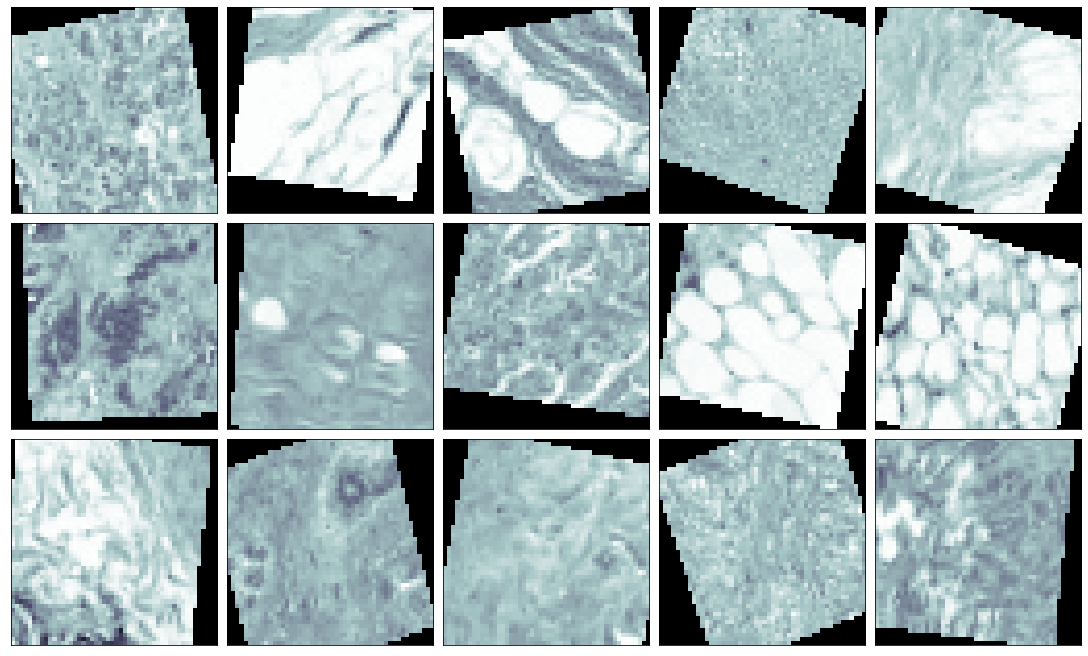

In [18]:
from tqdm import tqdm
#get the first patch for visualization
images1, labels1 = train_generator1.next()

n_row = 3
n_col = 5

fig, ax = plt.subplots(n_row, n_col, figsize = (n_col*3, n_row*3), constrained_layout = True)

for row in tqdm(range(n_row)):
    
    for col in range(n_col):
        
        ax[row][col].imshow(images1[row*n_col + col,:,:,0], cmap = 'bone')
        ax[row][col].set_xticks([])
        ax[row][col].set_yticks([])

In [19]:
#get the augmented data
train_data1=np.concatenate([train_generator1.next()[0] for i in range(train_generator1.__len__())])
train_label1=np.concatenate([train_generator1.next()[1] for i in range(train_generator1.__len__())])
print(train_data1.shape)
print(train_label1.shape)
#print(train_label1)

(110300, 50, 50, 3)
(110300, 2)


In [20]:
train_data2=np.concatenate((train_data,train_data1))
train_label2=np.concatenate((train_label,train_label1))
print(train_data2.shape)
print(train_label2.shape)

In [ ]:
train_data2, train_label2 = shuffle(train_data2, train_label2, random_state=0)

In [ ]:
train_datagen2 = ImageDataGenerator(rescale = 1.0/255)
train_generator = train_datagen2.flow(train_data2,
                                     train_label2, 
                                     batch_size = 16, 
                                     shuffle = False)

In [ ]:
#get the first patch for visualization
images2, labels2 = train_generator.next()
n_row = 3
n_col = 5

fig, ax = plt.subplots(n_row, n_col, figsize = (n_col*3, n_row*3), constrained_layout = True)

for row in tqdm(range(n_row)):
    
    for col in range(n_col):
        
        ax[row][col].imshow(images2[row*n_col + col,:,:,0], cmap = 'bone')
        ax[row][col].set_xticks([])
        ax[row][col].set_yticks([])
#print(val2_generator)

In [ ]:
train_label2_2=np.concatenate([train_generator.next()[1] for i in range(train_generator.__len__())])
print(train_label2_2.shape)

In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
import glob
IMG_SHAPE=(img_x, img_x, 3)
model_checkpoint2 = ModelCheckpoint(filepath=MODEL_PATH,  monitor='val_acc', verbose=1, save_best_only=True, mode='max')
#model_checkpoint2 = ModelCheckpoint(filepath=MODEL_PATH,  monitor='val_loss', verbose=1, save_best_only=True, mode='min')
board2 = TensorBoard(log_dir=board_name2,
                     histogram_freq=0,
                     write_graph=True,
                     write_images=True)
callback_list2 = [model_checkpoint2, board2, EarlyStopping(monitor='val_acc', patience=20)]
learning_rate = 0.00001
decay = 1e-6
momentum = 0.8
nesterov = True
sgd_optimizer = keras.optimizers.SGD(lr = learning_rate, decay = decay,            
                    momentum = momentum, nesterov = nesterov)
model.compile(loss = [focal_loss(gamma=2)], optimizer = sgd_optimizer, metrics = ['acc'])

nb_train_samples = size_4_training*0.7  
nb_validation_samples = size_4_training*0.3*0.3


history1=model.fit_generator(train_generator, steps_per_epoch=nb_train_samples /batch_size, epochs=epochs,
                    validation_data=val_generator, validation_steps=nb_validation_samples / batch_size,
                    verbose=1, shuffle=True, callbacks=callback_list2)
#history1=model.fit(
#   x=X_train,
#    y=y_train,
#    batch_size=32,
#    epochs=30,
#    verbose=1,
#    callbacks=callback_list2,
#    validation_split=0.0,
#    validation_data=(X_test, y_test),
#    shuffle=True,
#    class_weight=None,
#    sample_weight=None,
#    initial_epoch=0,
#    steps_per_epoch=None,
#    validation_steps=None,
#    validation_batch_size=None,
#    validation_freq=1,
#    max_queue_size=10,
#    workers=1,
#    use_multiprocessing=False
#)



In [ ]:
model.load_weights('./test_model.h5')

In [ ]:
import glob
nb_train_samples = len(train_label)  
nb_validation_samples = len(test_label)  
print(nb_train_samples //batch_size)
print(nb_validation_samples //batch_size)

In [ ]:
#显示第一次训练过程中accuracy和loss的变化
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (12, 6))
plt.subplot(121)
#plotting the Accuracy of test and training sets
plt.plot(history1.history['acc'])
plt.plot(history1.history['val_acc'])
plt.title('1st training Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(122)
#plotting the loss of test and training sets
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('1st training Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
import sklearn
from sklearn.metrics import f1_score, roc_auc_score, cohen_kappa_score, precision_score, recall_score, accuracy_score, confusion_matrix
#---------------
from keras.models import load_model

model.load_weights(MODEL_PATH)
print("analyse of 1st model")


cf_matrix_val = confusion_matrix(
    np.concatenate([np.argmax(val2_generator[i][1], axis=1) for i in range(len(val2_generator))]),    
    np.argmax(model.predict_generator(val2_generator, steps=len(val2_generator)), axis=1) 
)

plt.figure(figsize = (12, 6))
sns.heatmap(cf_matrix_val, annot=True, cmap='Blues')
plt.title("VAL Confusion matrix")
# kappa VAL
kappa_val = cohen_kappa_score(
    np.concatenate([np.argmax(val2_generator[i][1], axis=1) for i in range(len(val2_generator))]),    
    np.argmax(model.predict_generator(val2_generator, steps=len(val2_generator)), axis=1) 
)
print("VAL kappa")
print(kappa_val)



print("analyse 1st model")
print("report of val data")
report = sklearn.metrics.classification_report(
    np.concatenate([np.argmax(val2_generator[i][1], axis=1) for i in range(len(val2_generator))]),    
    np.argmax(model.predict_generator(val2_generator, steps=len(val2_generator)), axis=1) 
)
print(report)

In [ ]:
#------------------
cf_matrix_test = confusion_matrix(
    np.concatenate([np.argmax(val_generator[i][1], axis=1) for i in range(len(val_generator))]),    
    np.argmax(model.predict_generator(val_generator, steps=len(val_generator)), axis=1) 
)

plt.figure(figsize = (12, 6))
sns.heatmap(cf_matrix_test, annot=True, cmap='Blues')
plt.title("Test Confusion matrix")



print("report of test data")
import sklearn

report = sklearn.metrics.classification_report(
    np.concatenate([np.argmax(val_generator[i][1], axis=1) for i in range(len(val_generator))]),    
    np.argmax(model.predict_generator(val_generator, steps=len(val_generator)), axis=1) 
)
print(report)


# kappa TEST
kappa_test = cohen_kappa_score(
    np.concatenate([np.argmax(val_generator[i][1], axis=1) for i in range(len(val_generator))]),    
    np.argmax(model.predict_generator(val_generator, steps=len(val_generator)), axis=1) 
)
print("TEST kappa")
print(kappa_test)

import seaborn as sns
from sklearn.metrics import f1_score, roc_auc_score, cohen_kappa_score, precision_score, recall_score, accuracy_score, confusion_matrix

def test_2_final_model(model, train_generator, test_generator, val_generator, y_train, y_test, y_val, class_labels):
    
    # BS = 16
    ##results = dict()
    
    # n = len(testy)// BS

    # testX = testX[:BS*n]
    # testy = testy[:BS*n]

    ##print('Predicting test data')
    ##test_start_time = datetime.now()
    y_pred_test_original = model.predict_generator(test_generator,verbose=1)
    # y_pred = (y_pred_test>0.5).astype('int')

    y_pred_test = np.argmax(y_pred_test_original, axis = 1)
    #y_pred_test = y_pred_test_original
    #y_test = y_test.astype(int) # sparse form not categorical
    #y_train = y_train.astype(int) # sparse form not categorical
    #y_val = y_val.astype(int) # sparse form not categorical
    # y_test = np.argmax(testy, axis= 1)
    #y_test = np.argmax(testy, axis=-1)
    y_test = np.argmax(y_test, axis= 1)
    y_train = np.argmax(y_train, axis= 1)
    y_val = np.argmax(y_val, axis= 1)
    ##test_end_time = datetime.now()
    ##print('Done \n \n')
    ##results['testing_time'] = test_end_time - test_start_time
    ##print('testing time(HH:MM:SS:ms) - {}\n\n'.format(results['testing_time']))
    ##results['predicted'] = y_pred_test


    # balanced_accuracy
    from sklearn.metrics import balanced_accuracy_score
    ##balanced_accuracy = balanced_accuracy_score(y_true=y_test, y_pred=y_pred_test)
    ##print('---------------------')
    ##print('| Balanced Accuracy  |')
    ##print('---------------------')
    ##print('\n    {}\n\n'.format(balanced_accuracy))

    
    # calculate overall accuracty of the model
    ##accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_pred_test)
    # store accuracy in results
    ##results['accuracy'] = accuracy
    ##print('---------------------')
    ##print('|      Accuracy      |')
    ##print('---------------------')
    ##print('\n    {}\n\n'.format(accuracy))
    

    # get classification report
    ##print('-------------------------')
    ##print('| Classifiction Report |')
    ##print('-------------------------')
    ##classification_report = metrics.classification_report(y_test, y_pred_test)
    # store report in results
    ##results['classification_report'] = classification_report
    ##print(classification_report)
    
    
    
    # confusion matrix
    ##cm = metrics.confusion_matrix(y_test, y_pred_test)
    ##results['confusion_matrix'] = cm
    ##if print_cm: 
    ##    print('--------------------')
    ##    print('| Confusion Matrix |')
    ##    print('--------------------')
    ##    print('\n {}'.format(cm))
        
    # plot confusin matrix
    ##plt.figure(figsize=(6,4))
    ##plt.grid(b=False)
    ##plot_confusion_matrix(cm, classes=class_labels, normalize=True, title='Normalized confusion matrix')
    ##plt.show()
    

    
    # add the trained  model to the results
    ##results['model'] = model
    ##print("calculate other score")
    ##print("predicting validation data")

    #calculate other score
    y_pred_val_original = model.predict_generator(val_generator,verbose=1)
    # y_pred = (y_pred_val>0.5).astype('int')

    y_pred_val = np.argmax(y_pred_val_original, axis=1)
    # y_val = np.argmax(valy, axis= 1)
    #y_val = np.argmax(valy, axis=-1)
    print("predicting test data")
    y_pred_train_original = model.predict_generator(train_generator,verbose=1)
    # y_pred = (y_pred_train>0.5).astype('int')

    y_pred_train = np.argmax(y_pred_train_original,axis=1)
    # y_train = np.argmax(trainy, axis= 1)
    #y_train = np.argmax(trainy, axis=-1)
    
    print("Train accuracy Score------------>")
    print ("{0:.3f}".format(accuracy_score(y_train, y_pred_train)*100), "%")
    
    print("Val accuracy Score--------->")
    
    print("{0:.3f}".format(accuracy_score(y_val, y_pred_val)*100), "%")
    

    
  
    print("Test accuracy Score--------->")
    print("{0:.3f}".format(accuracy_score(y_test, y_pred_test)*100), "%")
    
    print("F1 Score--------------->")
    print("{0:.3f}".format(f1_score(y_test, y_pred_test, average = 'weighted')*100), "%")
    
    print("Cohen Kappa Score------------->")
    print("{0:.3f}".format(cohen_kappa_score(y_test, y_pred_test)*100), "%")
    
    print("Recall-------------->")
    print("{0:.3f}".format(recall_score(y_test, y_pred_test, average = 'weighted')*100), "%")
    
    print("Precision-------------->")
    print("{0:.3f}".format(precision_score(y_test, y_pred_test, average = 'weighted')*100), "%")
    
    cf_matrix_test = confusion_matrix(y_test, y_pred_test)
    cf_matrix_val = confusion_matrix(y_val, y_pred_val)
    
    plt.figure(figsize = (12, 6))
    plt.subplot(121)
    sns.heatmap(cf_matrix_val, annot=True, cmap='Blues')
    plt.title("Val Confusion matrix")
    
    plt.subplot(122)
    sns.heatmap(cf_matrix_test, annot=True, cmap='Blues')
    plt.title("Test Confusion matrix")
    
    plt.show()
    from sklearn.metrics import classification_report
    print("classification report")
    print(classification_report(y_val, y_pred_val))
    
    return

test_2_final_model(model, train_generator, 
               val_generator, val2_generator, 
               train_label,
               test_label,
               val_label, 
               class_labels = ['idc-', 'idc+'])

In [ ]:
#print(np.argmax(model.predict_generator(train_generator), axis=1))


In [ ]:
#y_train.astype(int)